# Motif K-mer Analysis

## Imports

In [1]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = ".jenhantao@gmail.com"

### imports ###
import sys
import os
import pandas as pd
import numpy as np
import argparse
import matplotlib
import itertools
import scipy
import matplotlib.pyplot as plt 
import seaborn as sns
import pickle
import sklearn

### notebook specific configuration ###
%matplotlib inline
sys.path.append("/home/jtao/code/seq_merge_pipe/")
matplotlib.pylab.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
os.chdir('/gpfs/data01/glasslab/home/jtao/analysis/kmer_analysis/')
sns.set_context('notebook')
%load_ext autoreload
%autoreload 2
%env PATH=/gpfs/data01/glasslab/home/jtao/perl5/bin:/gpfs/data01/glasslab/home/jtao/software/anaconda3/bin:/home/jtao/software/bin:/usr/local/sbin:/usr/sbin:/usr/bin:/usr/local/bin:/usr/bin:/gpfs/data01/glasslab/home/jtao/software/homer/bin:/gpfs/data01/glasslab/home/jtao/software/weblogo:/home/jtao/code/seq_merge_pipe:/home/vlink/mouse_strains/marge/shifting:/bioinformatics/glassutils/scripts:/bioinformatics/software/meme/bin



env: PATH=/gpfs/data01/glasslab/home/jtao/perl5/bin:/gpfs/data01/glasslab/home/jtao/software/anaconda3/bin:/home/jtao/software/bin:/usr/local/sbin:/usr/sbin:/usr/bin:/usr/local/bin:/usr/bin:/gpfs/data01/glasslab/home/jtao/software/homer/bin:/gpfs/data01/glasslab/home/jtao/software/weblogo:/home/jtao/code/seq_merge_pipe:/home/vlink/mouse_strains/marge/shifting:/bioinformatics/glassutils/scripts:/bioinformatics/software/meme/bin


## Read in Motifs

### convert MEME motif database text file into individual motifs



In [4]:
converted_motifs_dir = './individual_motifs/'
if not os.path.isdir(converted_motifs_dir):
    os.mkdir(converted_motifs_dir)
else:
    for f in os.listdir(converted_motifs_dir):
        os.remove(converted_motifs_dir + '/' + f)
        
with open('JASPAR_CORE_2016_vertebrates.meme') as f:
    data = f.readlines()
    
currentLines = [data[9]]
for line in data[9:]:
    if 'MOTIF' in line:
        motifName = currentLines[0].strip().split()[-1]
        outFile = open(converted_motifs_dir + '/' + motifName + '.fimo', 'w')
        outFile.write('MEME version 4.4\n\nALPHABET= ACGT\n\nstrands: + -\n\nBackground letter frequencies (from uniform background):\nA 0.25000 C 0.25000 G 0.25000 T 0.25000 ')
        for cl in currentLines:
            outFile.write(cl)
        outFile.close()
        currentLines = [line]
    else:
        currentLines.append(line)

### Read in individual Motifs

In [34]:
motif_dir = './individual_motifs/'
motif_matrix_dict = {}
for mf in os.listdir(motif_dir):
    with open(motif_dir + '/' + mf) as f:
        data = f.readlines()
    motif_name = data[7].strip().split()[-1]
    freqs = []
    for pwm_line in data[10:-3]:
        tokens = pwm_line.strip().split('\t')
        freqs.append([float(x.strip()) for x in tokens])
    
    motif_matrix_dict[motif_name] = freqs
    

## Construct K-mers

In [91]:
# size of biggest motif
max_size = np.max([len(motif_matrix_dict[x]) for x in motif_matrix_dict.keys()])

In [150]:
threshold = 0.3
z_threshold = 2.0
pos_nuc_dict = dict(zip(range(4),['A', 'C', 'G', 'T']))
max_kmer_size = 10
total_possible_list = []
num_observed_list = []
num_significant_list = []
k_list = []
for kmer_target_length in range(1,max_kmer_size+1):
    print('looking at ' + str(kmer_target_length)+'-mers')
    num_possible = np.power(4,kmer_target_length)
    total_possible_list.append(num_possible)
    k_list.append(kmer_target_length)
    kmers = []
    for motif_name in sorted(motif_matrix_dict.keys()):
        current_motif = motif_matrix_dict[motif_name]
        current_nucs = []
        kmer_length = np.min([len(current_motif), kmer_target_length])
        for pwm_pos in range(len(current_motif)):
            significant_nucs = []
            current_freqs = current_motif[pwm_pos]
            if current_freqs[0] >= threshold:
                significant_nucs.append('A')
            if current_freqs[1] >= threshold:
                significant_nucs.append('C')
            if current_freqs[2] >= threshold:
                significant_nucs.append('G')
            if current_freqs[3] >= threshold:
                significant_nucs.append('T')
            current_nucs.append(significant_nucs)
            if len(current_nucs) == kmer_length:
                current_kmers = itertools.product(*current_nucs)
                for km in current_kmers:
                    kmers.append(''.join(km))
                current_nucs = current_nucs[1:] # increment sliding window
    numObserved = len(set(kmers))
    motif_counts = Counter(kmers)
    count_values = list(motif_counts.values())
    zscores = scipy.stats.zscore(count_values)
    numSignificant = np.sum(zscores>=z_threshold)
    print('shapiro p-val:',scipy.stats.shapiro(count_values)[1])
    num_observed_list.append(numObserved)
    num_significant_list.append(numSignificant)

looking at 1-mers
shapiro p-val: 0.2889775037765503
looking at 2-mers
shapiro p-val: 0.04585282504558563
looking at 3-mers
shapiro p-val: 5.743105793953873e-05
looking at 4-mers
shapiro p-val: 1.0469322595851722e-16
looking at 5-mers
shapiro p-val: 3.2724102647838156e-40
looking at 6-mers
shapiro p-val: 0.0
looking at 7-mers
shapiro p-val: 0.0
looking at 8-mers
shapiro p-val: 0.0
looking at 9-mers
shapiro p-val: 0.0
looking at 10-mers
shapiro p-val: 0.0


/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/scipy/stats/morestats.py:1329: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


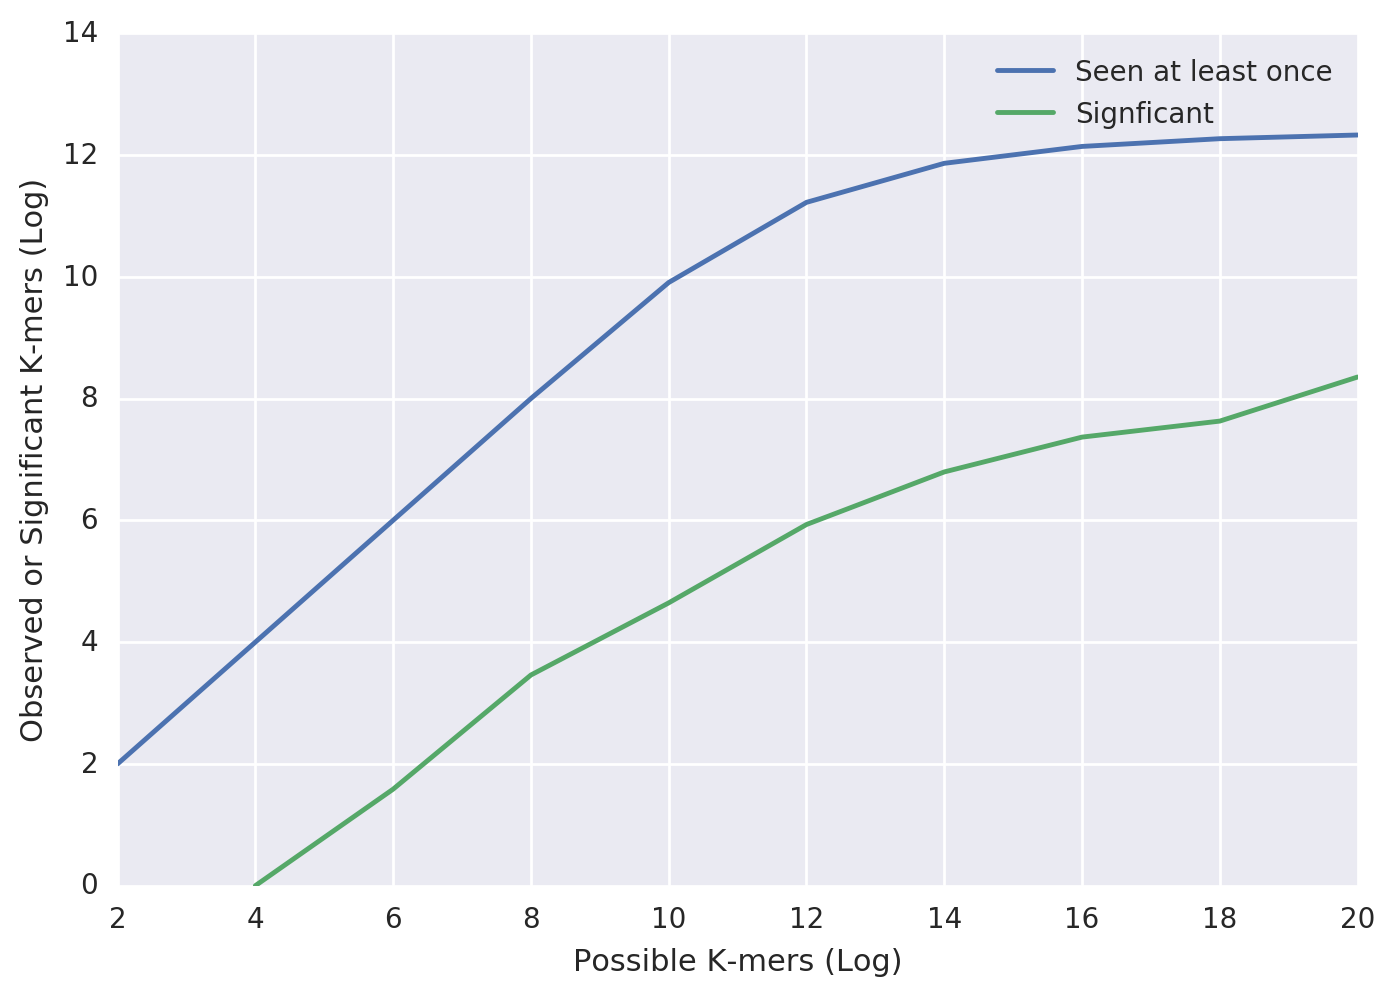

In [153]:
plt.plot(np.log2(total_possible_list), 
         np.log2(num_observed_list),
         label='Seen at least once'
            )
plt.plot(np.log2(total_possible_list), 
            np.log2(num_significant_list),
            label='Signficant')
plt.legend()
plt.xlabel('Possible K-mers (Log)')
plt.ylabel('Observed or Significant K-mers (Log)')


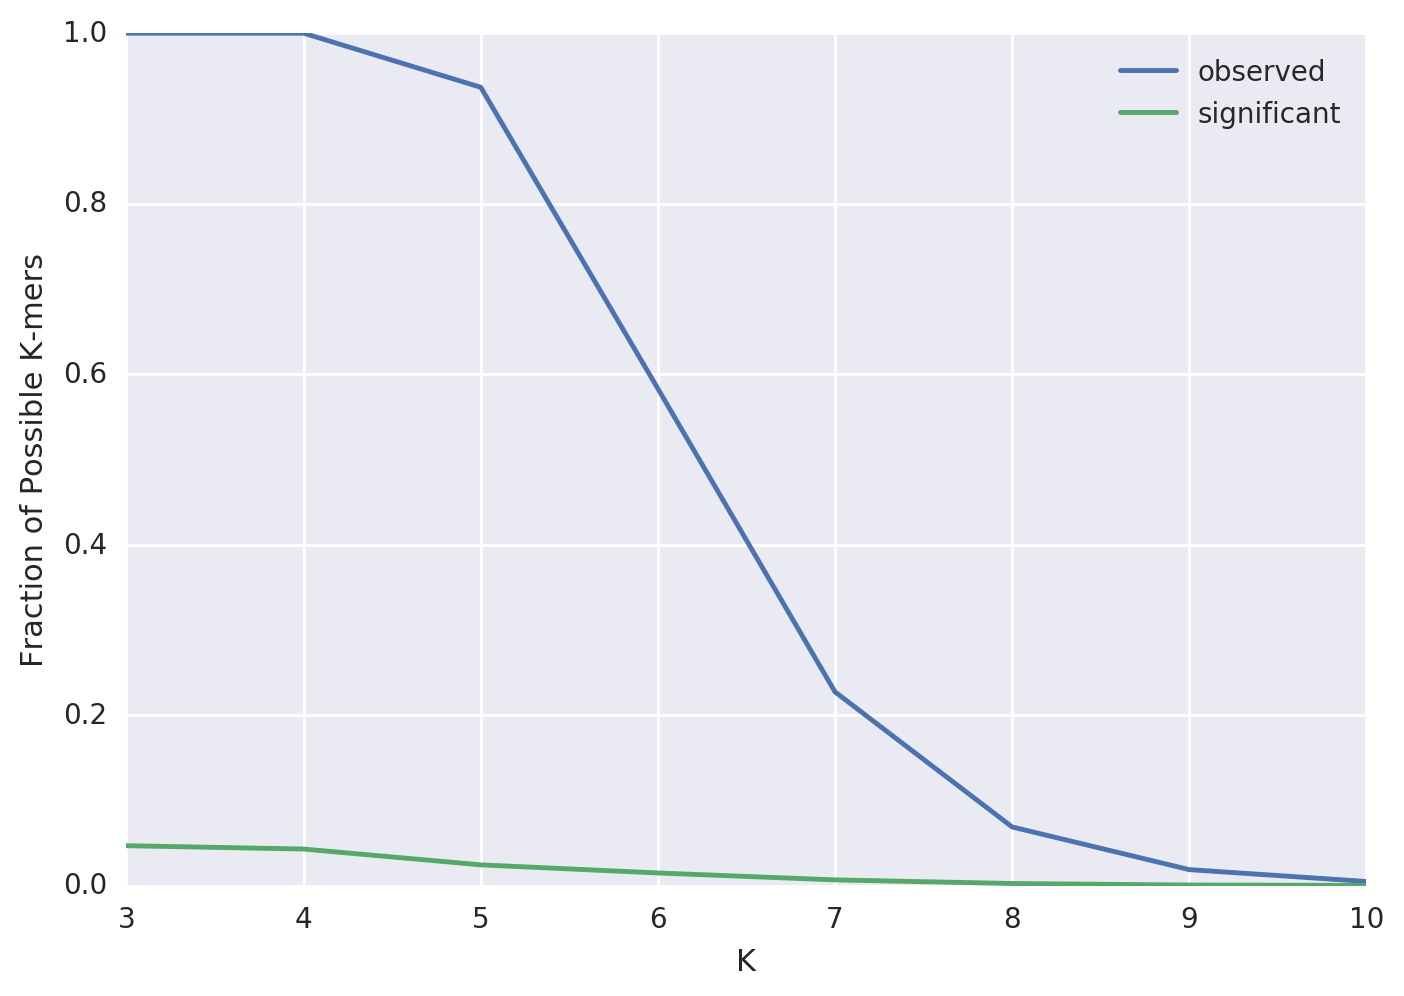

In [157]:
observed_fractions = np.array(num_observed_list)/np.array(total_possible_list)
significant_fractions = np.array(num_significant_list)/np.array(total_possible_list)
plt.plot(k_list, 
         observed_fractions,
         label='observed'
            )
plt.plot(k_list, 
         significant_fractions,
         label='significant'
            )
plt.legend()
plt.xlim(3,10)
plt.xlabel('K')
plt.ylabel('Fraction of Possible K-mers')



/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


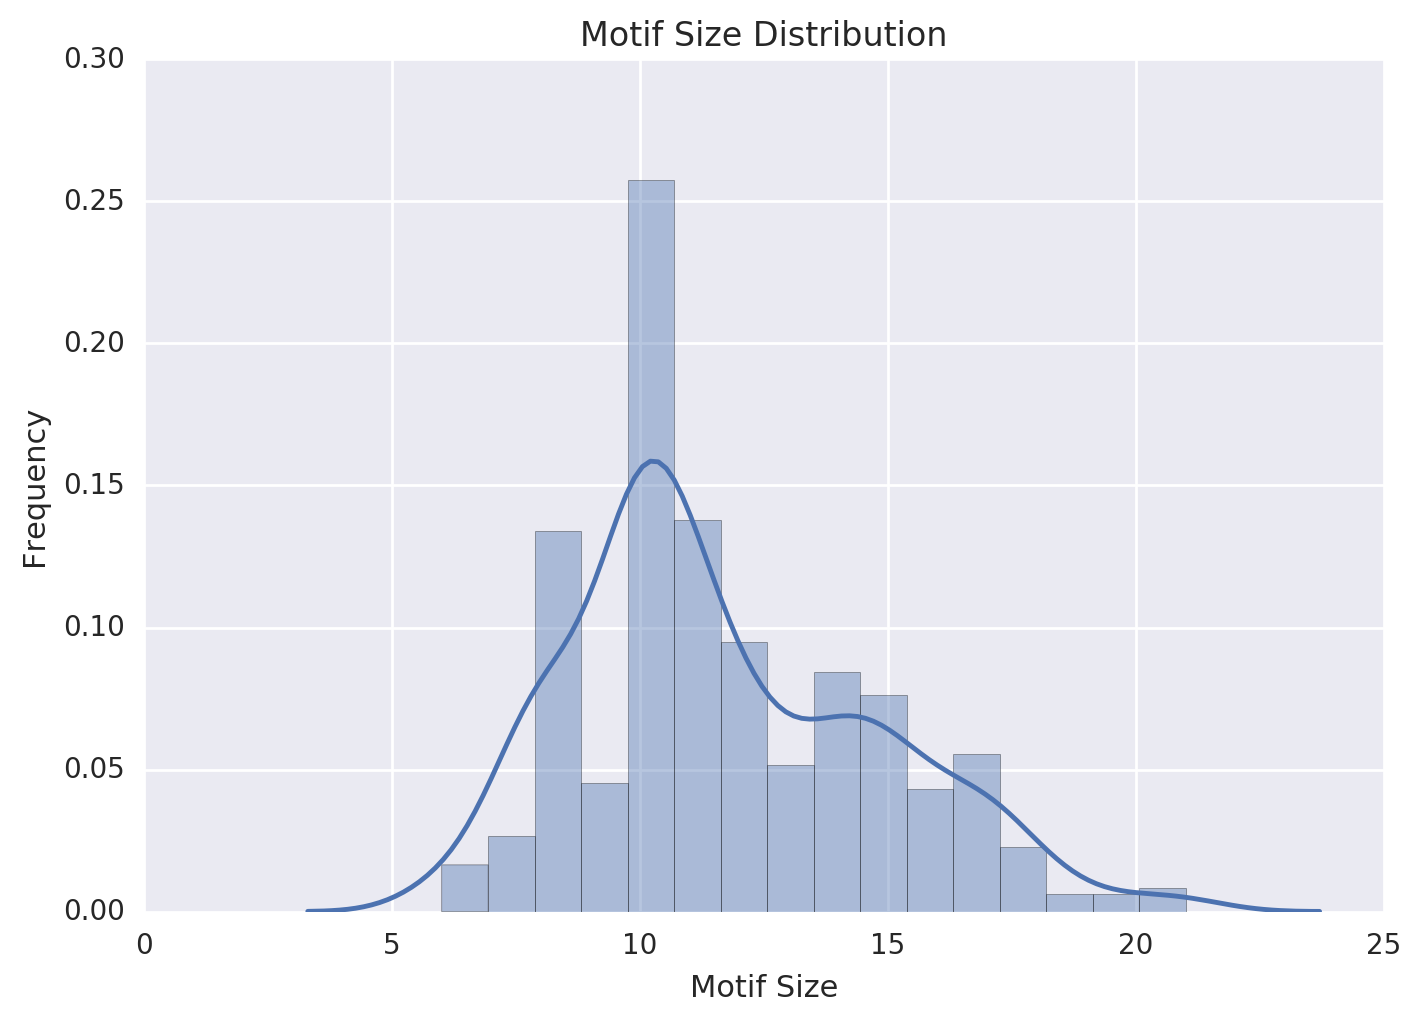

In [107]:
sns.distplot([len(motif_matrix_dict[x]) for x in motif_matrix_dict.keys()])
plt.ylabel('Frequency')
plt.xlabel('Motif Size')
plt.title('Motif Size Distribution')

## Distribution of K-mer counts

In [108]:
from collections import Counter

In [159]:
threshold = 0.3
pos_nuc_dict = dict(zip(range(4),['A', 'C', 'G', 'T']))
max_kmer_size = 10
count_list = []
k_list = []
normed_count_list = []
for kmer_target_length in range(1,max_kmer_size+1):
    print('looking at ' + str(kmer_target_length)+'-mers')
    num_possible = np.power(4,kmer_target_length)
    total_kmers.append(num_possible)
    k.append(kmer_target_length)
    kmers = []
    for motif_name in sorted(motif_matrix_dict.keys()):
        current_motif = motif_matrix_dict[motif_name]
        current_nucs = []
        kmer_length = np.min([len(current_motif), kmer_target_length])
        for pwm_pos in range(len(current_motif)):
            significant_nucs = []
            current_freqs = current_motif[pwm_pos]
            if current_freqs[0] >= threshold:
                significant_nucs.append('A')
            if current_freqs[1] >= threshold:
                significant_nucs.append('C')
            if current_freqs[2] >= threshold:
                significant_nucs.append('G')
            if current_freqs[3] >= threshold:
                significant_nucs.append('T')
            current_nucs.append(significant_nucs)
            if len(current_nucs) == kmer_length:
                current_kmers = itertools.product(*current_nucs)
                for km in current_kmers:
                    kmers.append(''.join(km))
                current_nucs = current_nucs[1:] # increment sliding window
    motif_counts = Counter(kmers)
    count_values = list(motif_counts.values())
    k_list = k_list + [kmer_target_length] * len(count_values)
    count_list = count_list + count_values
    normed_count_list = normed_count_list + list(scipy.stats.zscore(count_values))

looking at 1-mers
looking at 2-mers
looking at 3-mers
looking at 4-mers
looking at 5-mers
looking at 6-mers
looking at 7-mers
looking at 8-mers
looking at 9-mers
looking at 10-mers


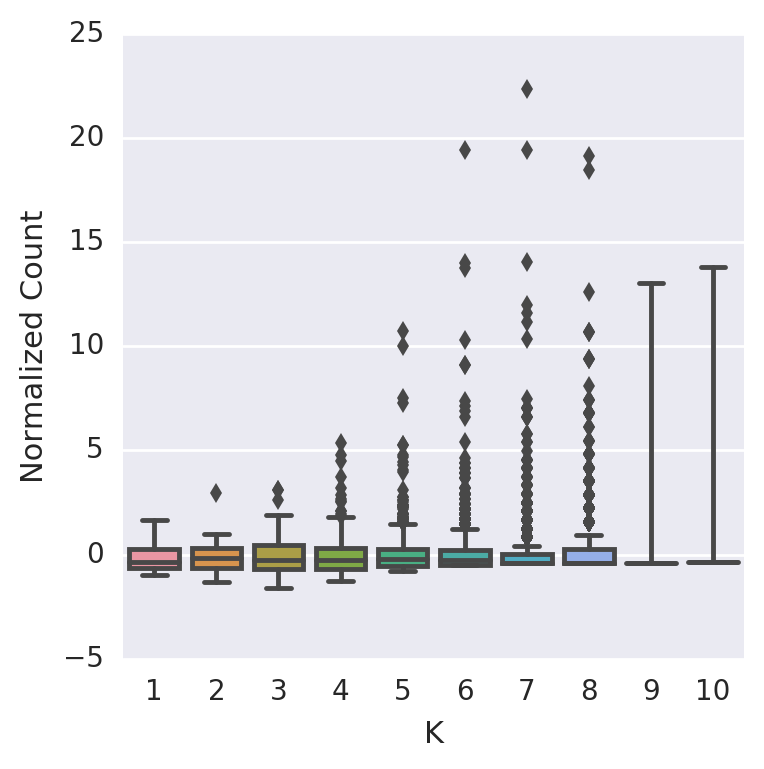

In [161]:
frame = pd.DataFrame({'K':k_list,
                     'Count':count_list,
                     'Normalized Count':normed_count_list,
                      'Log Count':np.log2(np.array(count_list) + 1)
                      })
sns.factorplot(data = frame, 
             x = 'K',
             y = 'Normalized Count',
             kind='box')